# Anlaysis of EWAS DNA Methylation Data 589 Male samples
(Using DNA Mehtylation to predict age)

## Below is the search criteria I have used, under advanced search, to get the methylation data.

I have downloaded the two set of 500 samples and combined them. The site will only let you download 500 samples at a time. The settings shown gets data with:
* age over 20 years old.
* from whole blood cells
* control people not diseased
* from a microarray platform with 450K test CpGs

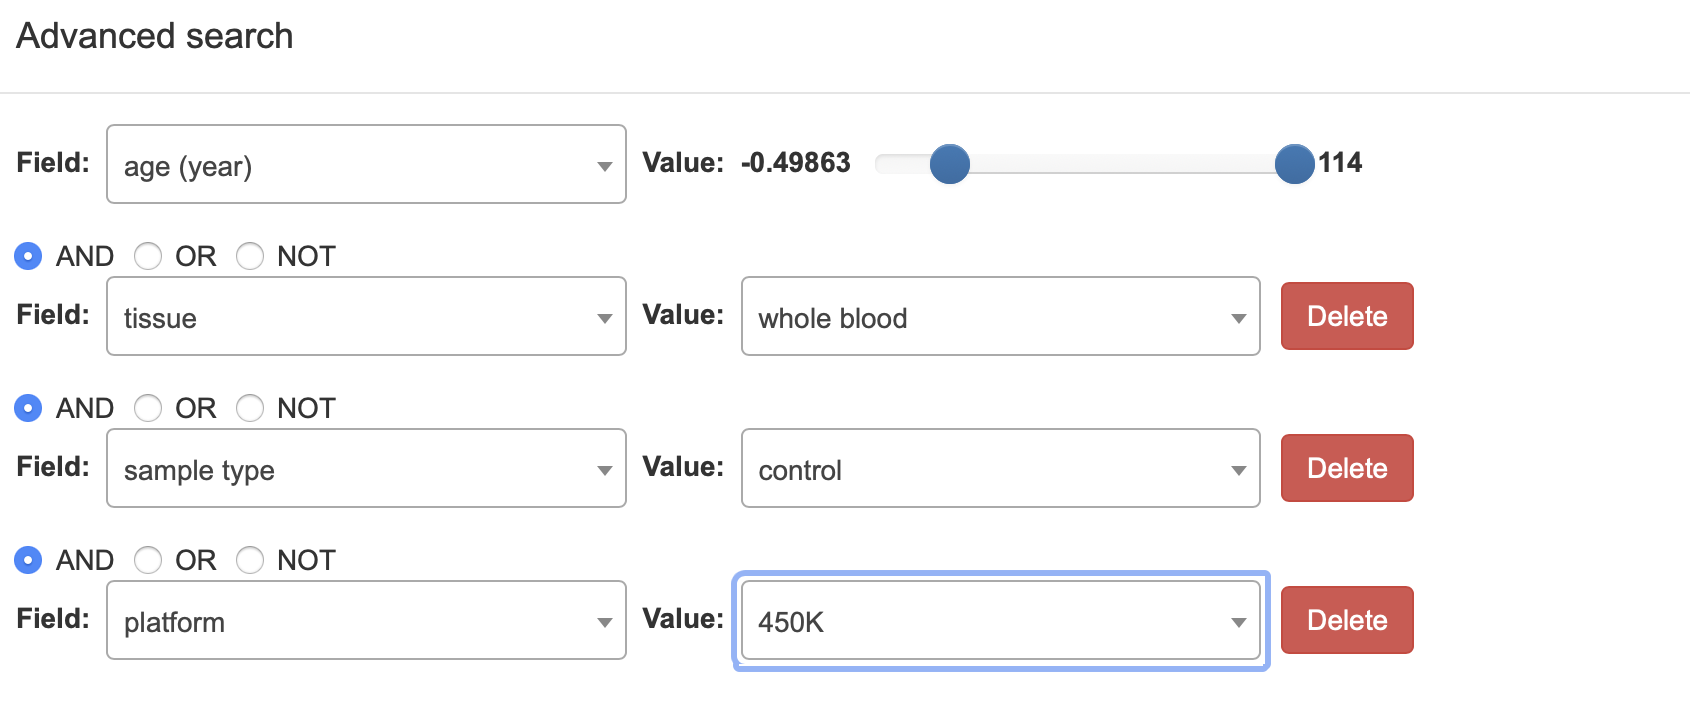

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Functions for processing EWAS methylation data to a dataframe

In [2]:

# Takes a metadata file in json format and reads it in to a list of dicts
def meta_data_to_list_of_dicts(files):
    metas = []
    for file in files:
        with open(file) as f:
            metas.append(json.load(f))
    all_metas = []
    for m in metas:
        all_metas = all_metas + m
    return all_metas


# Go through meta_dict a sample at a time and load data files into a new dataframe
# and then merge them all into 1 df
def process_EWAS_to_raw_df(meta):
    list_of_dfs = []
    ages = []
    sexes = []
    tissues = []
    samples = []
    platforms = []
    projects = []
    for s in meta:
        project = s['project id']
        sample = s['sample id']
        ages.append(s['age (year)'])
        if 'sex' in s.keys():
            sexes.append(s['sex'])
        else:
            sexes.append('U')
        samples.append(sample)
        tissues.append(s['tissue'])
        platforms.append(s['platform'])
        projects.append(project)
        df = pd.read_csv(str(project) + '/' + str(sample) + '.txt', sep = '\t', header=None)
        df.columns = ['cpg', 'sample_'+ sample]
        df.set_index('cpg', drop=True, inplace=True)
        list_of_dfs.append(df)
    df_all = list_of_dfs[0].join(list_of_dfs[1:])
    df_raw = df_all.dropna()
    #df_raw = df_all
    return df_raw, projects, ages, sexes, samples, tissues, platforms


# Transpose a raw EWAS dataframe and add metadata columns
def transpose_raw_df_and_add_metadata(df, projects, ages, sexes, samples, tissues, platforms):
    df = df.transpose()
    df.insert(0, "project", projects)
    df.insert(0, "platform", platforms)
    df.insert(0, "tissue", tissues)
    df.insert(0, "sex", sexes)
    df.insert(0, "age", ages)
    df_inverted = df.rename_axis(' ', axis=1)
    return df_inverted

# Combine a list of raw EWAS dataframes put out by process_EWAS_to_raw_df into 1 dataframe
def combine_EWAS_raw_dfs(list_of_raw_dfs):
    df_all = list_of_raw_dfs[0].join(list_of_dfs[1:])
    return df_all

### Functions for running Linear Lasso and XGBoost Regression and plotting results

In [3]:
# Run Linear Regression model and plot and print results
from sklearn.linear_model import LinearRegression
def linear_regress(X_train, y_train, X_test, y_test, plot=True):
    
    #Build fit model
    mod = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs='None')
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(25,6))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Linear Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Linear Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    
    return mod, rms_train, rms_test, r2_train, r2_test



In [4]:
# Function for running a lasso Regression model with CV on alpha
# and plot and print results
from sklearn.linear_model import LassoCV
def lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = mod = LassoCV(alphas=alphas,cv=cv)
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Lasso Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Lasso Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [5]:
# Function for running XGboost regression and print results
from xgboost import XGBRegressor
def xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=None, plot=True):
    
    #Build fit model
    XG = XGBRegressor(objective='reg:squarederror')
    eval_set = [(X_train, y_train),(X_test, y_test)]
    XG.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds = early_stopping_rounds,
               eval_set=eval_set, verbose=False)
    
    # Make predictions and evaluate
    preds_train = XG.predict(X_train)
    preds_test = XG.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    results = XG.evals_result()
    epochs = len(results['validation_0']['rmse'])
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,3, figsize=(30,6))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('XGboost on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('XGboost on testing data')

        x_axis = range(0, epochs)
        ax[2].plot(x_axis, results['validation_0']['rmse'], label='Train')
        ax[2].plot(x_axis, results['validation_1']['rmse'], label='Test')
        ax[2].legend()
        ax[2].set_ylabel('rms')
        ax[2].set_xlabel('epoch')
        ax[2].set_title('XGBoost rms')
        plt.show()
    
    # print metric
    print(f'The number of training epochs was {epochs}')
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    
    return XG, rms_train, rms_test, r2_train, r2_test, XG.feature_importances_

### Load data and process to a dataframe

In [6]:
%%time
# Processing a folder of EWAS methylation files to a single dataframe
#
# This cell takes 12 minutes with 1000 samples.
#
# Requires:
#    All project folders in the same folder as this notebook
#    All metadata files in the same folder as this notebook
#    files = list of metadata files
#
# The cell will open the metadata files and for each sample therein create a dataframe and drop
# any rows (cpgs) with a NaN, and then merge them all into one, and then transpose the df
# and add meta data columns

files = ['ewas_datahub_metadata_1.txt', 'ewas_datahub_metadata_2.txt']
meta = meta_data_to_list_of_dicts(files)
df_raw, projects, ages, sexes, samples, tissues, platforms = process_EWAS_to_raw_df(meta)
df_processed = transpose_raw_df_and_add_metadata(df_raw, projects, ages, sexes, samples, tissues, platforms)

CPU times: user 6min 9s, sys: 3min 3s, total: 9min 12s
Wall time: 11min 3s


In [7]:
df_processed

,age,sex,tissue,platform,project,cg02494853,cg03706273,cg05213048,cg15295597,cg27539833,...,cg27665648,ch.22.17803970R,ch.22.107403R,ch.22.22597277R,ch.22.427671F,ch.22.467397R,ch.22.33863861F,ch.22.38010425R,ch.22.43177094F,ch.22.46830341F
sample_GSM1069224,84.0,F,whole blood,450K,GSE43414,0.014,0.011,0.718,0.016,0.854,...,0.898,0.135,0.001,0.001,0.002,0.001,0.009,0.005,0.000,0.002
sample_GSM1069230,82.0,F,whole blood,450K,GSE43414,0.021,0.098,0.851,0.041,0.912,...,0.893,0.146,0.001,0.001,0.002,0.001,0.016,0.003,0.000,0.003
sample_GSM1069231,80.0,F,whole blood,450K,GSE43414,0.031,0.078,0.608,0.034,0.928,...,0.911,0.097,0.002,0.002,0.002,0.002,0.015,0.004,0.000,0.003
sample_GSM1069233,88.0,M,whole blood,450K,GSE43414,0.032,0.057,0.829,0.043,0.934,...,0.888,0.122,0.002,0.001,0.002,0.002,0.014,0.004,0.000,0.003
sample_GSM1069234,74.0,F,whole blood,450K,GSE43414,0.013,0.047,0.576,0.023,0.931,...,0.927,0.117,0.001,0.001,0.002,0.001,0.019,0.004,0.000,0.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_GSM1343529,66.3,F,whole blood,450K,GSE55763,0.050,0.106,0.722,0.102,0.922,...,0.891,0.138,0.006,0.014,0.013,0.008,0.035,0.012,0.002,0.015
sample_GSM1343530,52.2,F,whole blood,450K,GSE55763,0.048,0.041,0.660,0.052,0.915,...,0.879,0.166,0.005,0.009,0.011,0.005,0.052,0.009,0.004,0.009
sample_GSM1343531,54.0,M,whole blood,450K,GSE55763,0.043,0.032,0.890,0.078,0.924,...,0.876,0.139,0.005,0.004,0.009,0.005,0.041,0.014,0.004,0.005
sample_GSM1343532,43.5,M,whole blood,450K,GSE55763,0.022,0.029,0.888,0.041,0.927,...,0.849,0.154,0.007,0.009,0.013,0.004,0.048,0.011,0.002,0.005


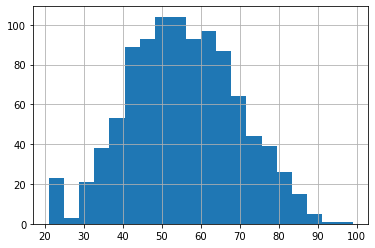

In [8]:
# Histogram of ages in data
df_processed.age.hist(bins=20)
plt.show()

In [140]:
# %%time
# df_processed.to_csv('df_processed.csv')

### Taking just the male data

In [9]:
df_processed_M = df_processed[df_processed.sex == 'M']

In [10]:
df_processed_M

,age,sex,tissue,platform,project,cg02494853,cg03706273,cg05213048,cg15295597,cg27539833,...,cg27665648,ch.22.17803970R,ch.22.107403R,ch.22.22597277R,ch.22.427671F,ch.22.467397R,ch.22.33863861F,ch.22.38010425R,ch.22.43177094F,ch.22.46830341F
sample_GSM1069233,88.0,M,whole blood,450K,GSE43414,0.032,0.057,0.829,0.043,0.934,...,0.888,0.122,0.002,0.001,0.002,0.002,0.014,0.004,0.000,0.003
sample_GSM1069236,75.0,M,whole blood,450K,GSE43414,0.013,0.021,0.735,0.028,0.935,...,0.887,0.128,0.002,0.002,0.004,0.001,0.024,0.006,0.000,0.002
sample_GSM1069241,99.0,M,whole blood,450K,GSE43414,0.013,0.017,0.715,0.017,0.932,...,0.886,0.161,0.001,0.002,0.005,0.003,0.026,0.005,0.000,0.003
sample_GSM1069248,82.0,M,whole blood,450K,GSE43414,0.025,0.025,0.669,0.042,0.942,...,0.929,0.148,0.001,0.002,0.004,0.002,0.030,0.005,0.001,0.004
sample_GSM1069250,78.0,M,whole blood,450K,GSE43414,0.022,0.011,0.665,0.023,0.950,...,0.887,0.161,0.002,0.002,0.010,0.002,0.042,0.010,0.001,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_GSM1343526,42.1,M,whole blood,450K,GSE55763,0.056,0.032,0.772,0.041,0.932,...,0.892,0.137,0.011,0.011,0.008,0.005,0.045,0.014,0.003,0.015
sample_GSM1343527,65.8,M,whole blood,450K,GSE55763,0.055,0.064,0.920,0.034,0.944,...,0.897,0.128,0.005,0.011,0.016,0.006,0.044,0.017,0.003,0.011
sample_GSM1343531,54.0,M,whole blood,450K,GSE55763,0.043,0.032,0.890,0.078,0.924,...,0.876,0.139,0.005,0.004,0.009,0.005,0.041,0.014,0.004,0.005
sample_GSM1343532,43.5,M,whole blood,450K,GSE55763,0.022,0.029,0.888,0.041,0.927,...,0.849,0.154,0.007,0.009,0.013,0.004,0.048,0.011,0.002,0.005


### Splitting data set into 439 rows for working 150 rows for saving

In [16]:
import random
np.random.seed(2021)
saved_index = np.random.choice(np.arange(1000), size=150, replace=False)
keep_index = []
for num in range(1000):
    if num not in saved_index:
        keep_index.append(num)

df_p_saved_M = df_processed.iloc[saved_index, :]
df_p_working_M = df_processed.iloc[keep_index, :]

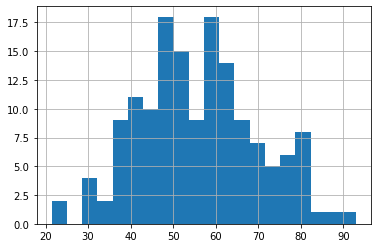

In [17]:
# Histogram of ages in saved data
df_p_saved_M.age.hist(bins=20)
plt.show()

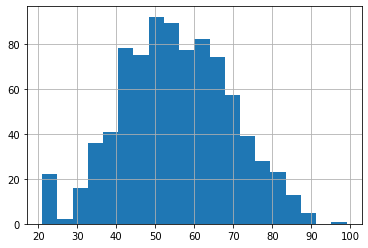

In [18]:
# Histogram of ages in saved data
df_p_working_M.age.hist(bins=20)
plt.show()

### Making train and test split from working data

In [19]:
from sklearn.model_selection import train_test_split
X = df_p_working_M.iloc[:, 5:]
y = df_p_working_M.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

#### Running Lasso on training and testing data with CV=5  on alpha

/Users/dcox/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.017655920158198, tolerance: 10.073803225247412
  model = cd_fast.enet_coordinate_descent(


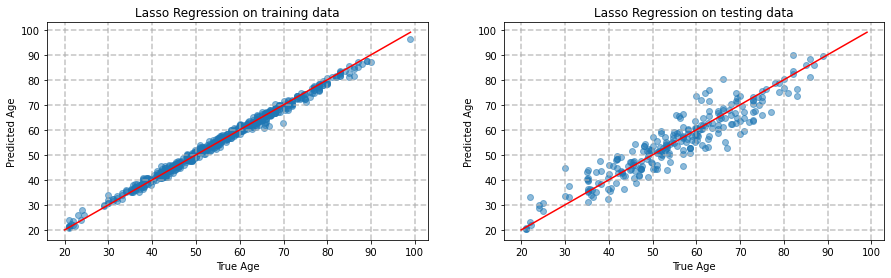

The rms on the training data is 1.289 years
The rms on the testing data is 5.040 years
The r^2 on the training data is 0.992
The r^2 on the testing data is 0.876
CPU times: user 19min 4s, sys: 27.7 s, total: 19min 31s
Wall time: 5min 54s


In [20]:
%%time
mod_M, rms_train, rms_test, r2_train, r2_test = lassoCV_regress(X_train, y_train, X_test, y_test, plot=True)

In [22]:
print(f'optimal alpha for lasso was {mod_M.alpha_}')

optimal alpha for lasso was 0.01


### Creating an new df with just cpgs from lasso with coefs > 0.1

In [24]:
cgs_series = pd.Series(mod_M.coef_, index=df_processed_M.columns[5:])
cgs_lasso_series = cgs_series[abs(cgs_series)>0.1]
print(f'lasso kept {len(cgs_lasso_series)} cpgs')
df_from_lasso = df_p_working_M[cgs_lasso_series.index]
df_from_lasso

lasso kept 396 cpgs


,cg12176110,cg12230162,cg21634944,cg02577267,cg04873098,cg05047401,cg08851727,cg09315878,cg12407057,cg12417704,...,cg24877093,cg00058879,cg00243527,cg01514353,cg07895657,cg11019791,cg16122736,cg17099656,cg18908811,cg24694833
sample_GSM1069224,0.336,0.581,0.545,0.521,0.442,0.140,0.907,0.855,0.626,0.900,...,0.498,0.166,0.856,0.207,0.412,0.881,0.376,0.400,0.680,0.485
sample_GSM1069231,0.272,0.586,0.529,0.621,0.653,0.257,0.943,0.683,0.587,0.898,...,0.705,0.165,0.897,0.206,0.660,0.924,0.445,0.504,0.639,0.472
sample_GSM1069233,0.376,0.273,0.013,0.500,0.695,0.127,0.635,0.806,0.478,0.862,...,0.909,0.232,0.486,0.279,0.554,0.925,0.877,0.277,0.409,0.517
sample_GSM1069234,0.279,0.340,0.289,0.524,0.441,0.078,0.702,0.900,0.452,0.905,...,0.569,0.199,0.924,0.365,0.580,0.533,0.890,0.017,0.638,0.915
sample_GSM1069236,0.246,0.291,0.008,0.549,0.731,0.180,0.820,0.699,0.639,0.675,...,0.487,0.141,0.885,0.248,0.629,0.905,0.419,0.048,0.150,0.857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_GSM1343528,0.108,0.695,0.555,0.592,0.675,0.156,0.895,0.835,0.693,0.923,...,0.555,0.140,0.470,0.270,0.731,0.926,0.741,0.246,0.692,0.055
sample_GSM1343529,0.325,0.666,0.544,0.471,0.773,0.150,0.903,0.701,0.805,0.241,...,0.650,0.222,0.476,0.210,0.709,0.467,0.809,0.290,0.620,0.903
sample_GSM1343530,0.353,0.701,0.551,0.606,0.630,0.203,0.859,0.763,0.625,0.912,...,0.651,0.185,0.478,0.369,0.684,0.906,0.714,0.486,0.608,0.046
sample_GSM1343531,0.287,0.692,0.014,0.337,0.608,0.124,0.628,0.788,0.790,0.900,...,0.356,0.148,0.874,0.374,0.909,0.920,0.718,0.279,0.549,0.888


### New train test split of working data with just 396 cpg columns

In [28]:
from sklearn.model_selection import train_test_split
X = df_from_lasso
y = df_p_working_M.age
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size=0.30, random_state = 2022)

### Run linear regression on working data with just the 396 columns

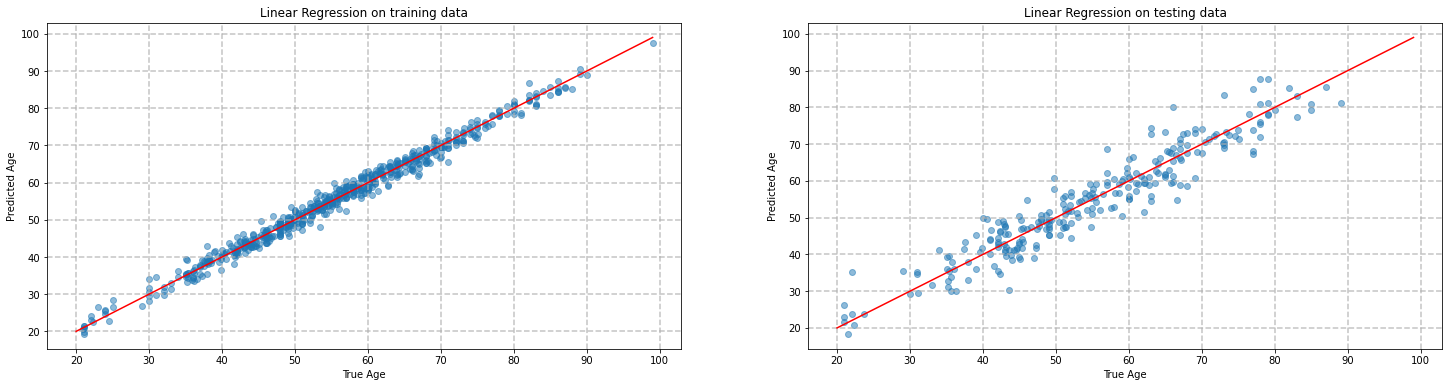

The rms on the training data is 1.637 years
The rms on the testing data is 4.530 years
The r^2 on the training data is 0.986
The r^2 on the testing data is 0.900
CPU times: user 1.34 s, sys: 26 ms, total: 1.37 s
Wall time: 252 ms


In [29]:
%%time
mod_lg_M, rms_train_lg, rms_test_lg, r2_train_lg, r2_test_lg = linear_regress(X_train_s, y_train_s, X_test_s, y_test_s, plot=True)

### Creating a data frame from the saved data with just the 396 cpg columns from lasso

In [30]:
df_p_saved_346_M = df_p_saved_M[df_from_lasso.columns]

### Seeing how well the last linear regression model model predicts on the saved data but with only 346 cpgs

In [32]:
X_saved = df_p_saved_346_M
y_saved = df_p_saved_M.age
preds_on_saved = mod_lg_M.predict(X_saved)
rms_test_s = (mean_squared_error(y_saved, preds_on_saved))**0.5
r2_test_s = r2_score(y_saved, preds_on_saved)

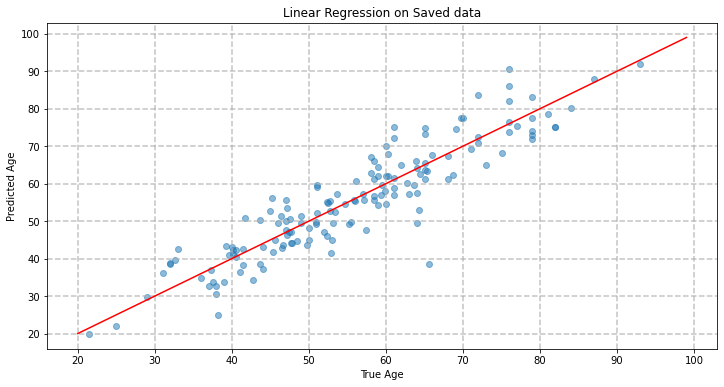

The rms on the saved data is 5.957 years
The r^2 on the saved data is 0.812


In [33]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.scatter(y_saved, preds_on_saved, alpha=0.5)
ax.plot(range(20,100), range(20,100), c='red')
ax.set_xlabel('True Age')
ax.set_ylabel('Predicted Age')
ax.grid(True, lw=1.5, ls='--', alpha=0.75)
ax.set_title('Linear Regression on Saved data')
plt.show()

# print metric
print(f'The rms on the saved data is {rms_test_s:.3f} years')
print(f'The r^2 on the saved data is {r2_test_s:.3f}')

In [34]:
# Save model as mod_lg1
import pickle
with open('mod_lg1_M', 'wb') as fp:
    pickle.dump(mod_lg_M, fp)

# To read it back:
# with open ('coefs_keep_800', 'rb') as fp:
#   coefs_keep = pickle.load(fp)

### Now trying to narrow down cpgs with XGboost rather than lasso

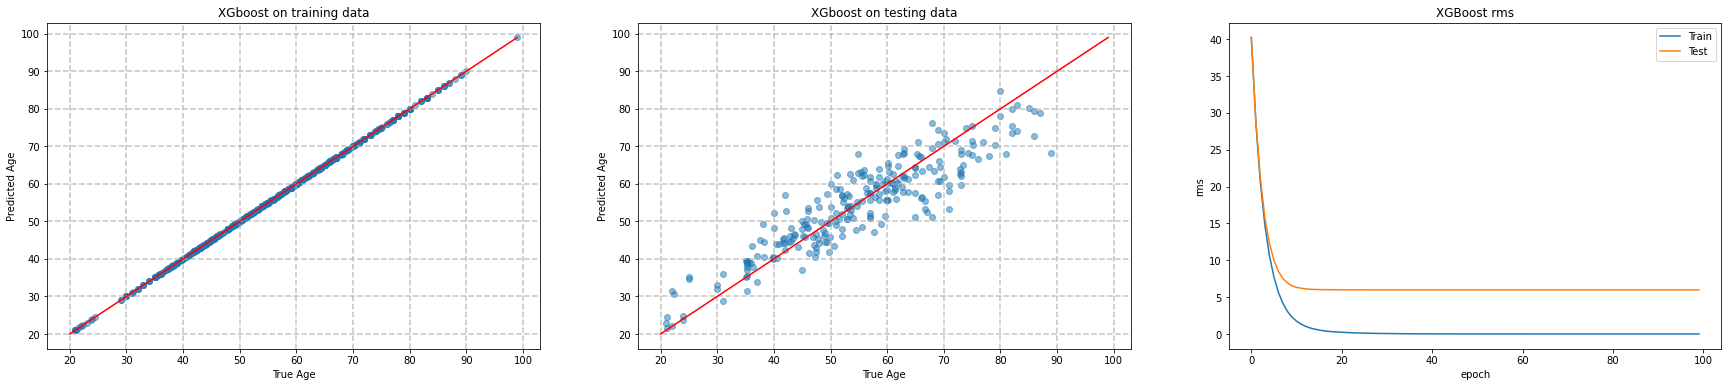

The number of training epochs was 100
The rms on the training data is 0.000 years
The rms on the testing data is 5.980 years
The r^2 on the training data is 1.000
The r^2 on the testing data is 0.825


In [35]:
# Running XGBoost regressor with default settings on
XG_M, rms_train_xg, rms_test_xg, r2_train_xg, r2_test_xg, feature_importances_xg = xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=None, plot=True)

In [36]:
# Making a dataframe with CpG names and importance scores ordered highest to lowest
df_importance  = pd.DataFrame({'CpG':df_p_working_M.columns[5:], 'Importance Score':feature_importances_xg})
df_importance_sorted  = df_importance.sort_values('Importance Score', ascending=False)
df_importance_sorted.head(20)

,CpG,Importance Score
64826,cg04875128,0.247802
55636,cg02805465,0.105086
13965,cg16926316,0.103881
32090,cg16867657,0.068292
3973,cg07418114,0.044174
68688,cg04208403,0.041422
30275,cg08453194,0.023478
118196,cg05360402,0.023175
15571,cg24010884,0.020740
130214,cg08097417,0.020509


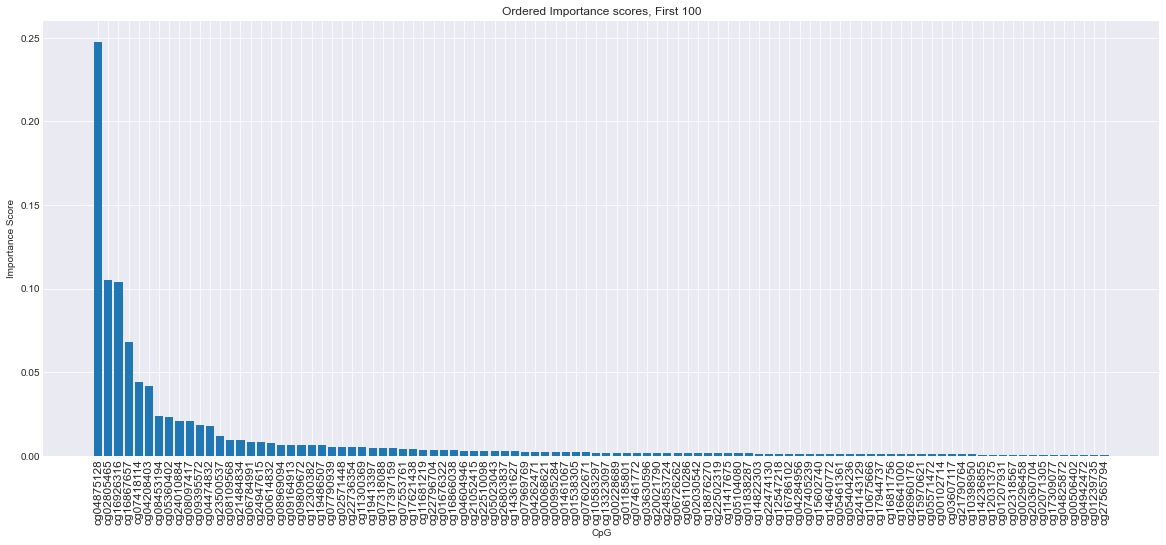

In [37]:
# Plotting the first 100 importance scores
plt.style.use('seaborn-darkgrid')
plt.figure(figsize = (20, 8))
plt.title('Ordered Importance scores, First 100')
plt.bar(df_importance_sorted['CpG'][:100], df_importance_sorted['Importance Score'][:100] )
plt.ylabel('Importance Score')
plt.xlabel('CpG')
plt.xticks(fontsize = 12, rotation=90)
plt.show()

 ### Creating a data frame from working data with just the 100 cpgs found by XGBoost

In [38]:
# Making a dataframe with just the most important 100 cpgs as judged by XGBoost
df_100_M = df_p_working_M[df_importance_sorted['CpG'][:100]]
df_100_M

,cg04875128,cg02805465,cg16926316,cg16867657,cg07418114,cg04208403,cg08453194,cg05360402,cg24010884,cg08097417,...,cg02318567,cg00296458,cg20360704,cg02071305,cg17309077,cg04825872,cg00506402,cg04942472,cg01239735,cg27565794
sample_GSM1069224,0.315,0.460,0.932,0.766,0.633,0.443,0.324,0.066,0.908,0.223,...,0.106,0.866,0.074,0.126,0.218,0.490,0.006,0.060,0.984,0.987
sample_GSM1069231,0.311,0.498,0.905,0.769,0.672,0.556,0.338,0.057,0.896,0.238,...,0.231,0.848,0.103,0.278,0.271,0.190,0.008,0.076,0.906,0.997
sample_GSM1069233,0.300,0.477,0.882,0.771,0.682,0.541,0.279,0.085,0.911,0.209,...,0.247,0.863,0.097,0.360,0.302,0.120,0.012,0.058,0.984,0.996
sample_GSM1069234,0.318,0.570,0.931,0.792,0.628,0.494,0.195,0.065,0.902,0.189,...,0.104,0.925,0.071,0.243,0.236,0.124,0.011,0.086,0.993,0.998
sample_GSM1069236,0.339,0.544,0.896,0.672,0.662,0.573,0.346,0.042,0.929,0.176,...,0.141,0.826,0.138,0.262,0.285,0.111,0.015,0.073,0.903,0.991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_GSM1343528,0.233,0.618,0.931,0.705,0.721,0.610,0.386,0.044,0.908,0.130,...,0.151,0.895,0.100,0.327,0.300,0.427,0.019,0.080,0.934,0.983
sample_GSM1343529,0.415,0.660,0.930,0.762,0.722,0.634,0.405,0.047,0.905,0.172,...,0.246,0.884,0.166,0.270,0.321,0.221,0.020,0.063,0.971,0.982
sample_GSM1343530,0.336,0.653,0.935,0.669,0.737,0.638,0.440,0.045,0.899,0.203,...,0.134,0.856,0.151,0.345,0.340,0.356,0.015,0.078,0.934,0.990
sample_GSM1343531,0.179,0.649,0.953,0.643,0.721,0.627,0.421,0.032,0.929,0.104,...,0.105,0.882,0.116,0.431,0.267,0.212,0.018,0.099,0.765,0.999


### Splitting the new data 100 cpg data to train and test

In [39]:
# Split data 80 / 20
from sklearn.model_selection import train_test_split
X = df_100_M
y = df_p_working_M.age
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(X, y, test_size=0.20, random_state = 2023)

### Running a linear regression model on the working data with just 100 cpgs

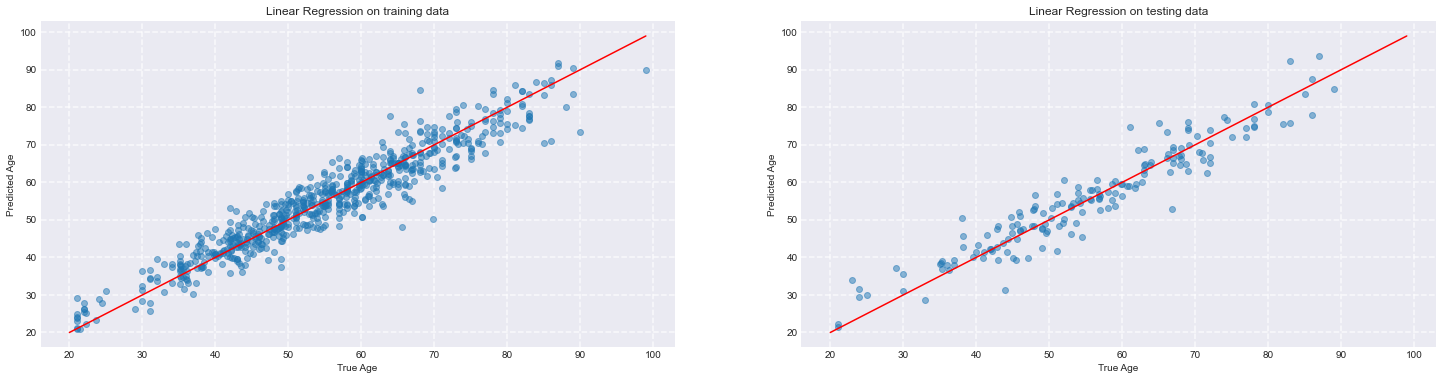

The rms on the training data is 4.302 years
The rms on the testing data is 4.484 years
The r^2 on the training data is 0.905
The r^2 on the testing data is 0.906
CPU times: user 1.22 s, sys: 23.1 ms, total: 1.24 s
Wall time: 226 ms


In [40]:
%%time
mod_lg2_M, rms_train_lg2, rms_test_lg2, r2_train_lg2, r2_test_lg2 = linear_regress(X_train_x, y_train_x, X_test_x, y_test_x, plot=True)

### Now checking the linear model just generated to see how well it predicts on the saved data

In [41]:
# Making a df of the savewd data with just 100 cog columns
df_p_saved_100_M = df_p_saved_M[df_importance_sorted['CpG'][:100]]

In [42]:
df_p_saved_100_M

,cg04875128,cg02805465,cg16926316,cg16867657,cg07418114,cg04208403,cg08453194,cg05360402,cg24010884,cg08097417,...,cg02318567,cg00296458,cg20360704,cg02071305,cg17309077,cg04825872,cg00506402,cg04942472,cg01239735,cg27565794
sample_GSM1300405,0.184,0.491,0.810,0.714,0.599,0.478,0.305,0.022,0.823,0.111,...,0.199,0.839,0.122,0.311,0.237,0.330,0.016,0.086,0.757,0.993
sample_GSM1300537,0.246,0.471,0.847,0.586,0.641,0.546,0.435,0.057,0.920,0.053,...,0.192,0.813,0.060,0.340,0.278,0.272,0.028,0.060,0.994,0.991
sample_GSM1343454,0.096,0.612,0.958,0.596,0.717,0.621,0.496,0.060,0.896,0.084,...,0.122,0.881,0.113,0.312,0.308,0.183,0.024,0.089,0.972,0.992
sample_GSM1300379,0.207,0.679,0.818,0.636,0.616,0.483,0.324,0.021,0.819,0.167,...,0.087,0.859,0.069,0.181,0.255,0.177,0.018,0.115,0.942,0.991
sample_GSM1343270,0.170,0.521,0.901,0.621,0.684,0.617,0.364,0.052,0.930,0.121,...,0.234,0.890,0.118,0.240,0.326,0.302,0.014,0.075,0.948,0.991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_GSM1343365,0.058,0.790,0.945,0.617,0.755,0.628,0.412,0.050,0.918,0.100,...,0.140,0.885,0.163,0.256,0.285,0.244,0.022,0.064,0.965,0.999
sample_GSM1343397,0.228,0.721,0.922,0.692,0.727,0.623,0.459,0.039,0.928,0.089,...,0.163,0.889,0.139,0.279,0.307,0.224,0.016,0.060,0.976,0.974
sample_GSM1343061,0.253,0.702,0.923,0.641,0.717,0.630,0.416,0.044,0.918,0.147,...,0.162,0.861,0.144,0.274,0.310,0.162,0.025,0.076,0.912,0.999
sample_GSM1343252,0.056,0.697,0.921,0.534,0.736,0.614,0.422,0.054,0.906,0.088,...,0.116,0.854,0.110,0.291,0.285,0.157,0.028,0.061,0.960,0.992


In [43]:
# Defining X and y from the saved data just 100 cpgs
X_saved_100 = df_p_saved_100_M
y_saved_100 = df_p_saved_M.age

In [46]:
# Using the LG model above to make predictions on the saved data
preds_on_saved2 = mod_lg2_M.predict(X_saved_100)
rms_test_s2 = (mean_squared_error(y_saved_100, preds_on_saved2))**0.5
r2_test_s2 = r2_score(y_saved_100, preds_on_saved2)

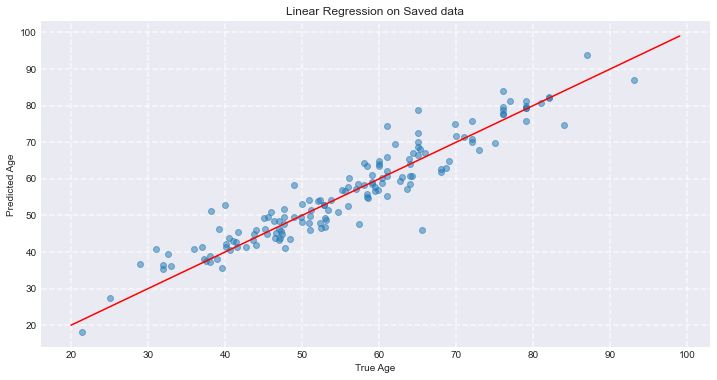

The rms on the saved data is 4.577 years
The r^2 on the saved data is 0.889


In [47]:
# Plotting results
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.scatter(y_saved, preds_on_saved2, alpha=0.5)
ax.plot(range(20,100), range(20,100), c='red')
ax.set_xlabel('True Age')
ax.set_ylabel('Predicted Age')
ax.grid(True, lw=1.5, ls='--', alpha=0.75)
ax.set_title('Linear Regression on Saved data')
plt.show()

# print metric
print(f'The rms on the saved data is {rms_test_s2:.3f} years')
print(f'The r^2 on the saved data is {r2_test_s2:.3f}')

### Wrapping up some things

In [48]:
# lists of cpgs from the two methods
cpgs_lasso = cgs_lasso_series.index
cpgs_XGboost = df_importance_sorted['CpG'][:100]

In [49]:
# Finding common cpgs from the lasso and XGboost methods of reducing the feature number
c = []
count=0
for cpg in cpgs_XGboost:
    if cpg in cpgs_lasso:
        c.append(cpg)
        count+=1
print(count)
c

11


['cg04875128',
 'cg16867657',
 'cg23500537',
 'cg09809672',
 'cg22736354',
 'cg07553761',
 'cg17621438',
 'cg22796704',
 'cg14361627',
 'cg20021790',
 'cg05404236']

In [50]:
# Saving models and cpg lists to files
import pickle
with open('mod_lg_M', 'wb') as fp:
    pickle.dump(mod_lg_M, fp)

with open('mod_lg2_M', 'wb') as fp:
    pickle.dump(mod_lg2_M, fp)

with open('cpgs_lasso_M', 'wb') as fp:
    pickle.dump(cpgs_lasso, fp)
    
with open('cpgs_XGboost_M', 'wb') as fp:
    pickle.dump(cpgs_XGboost, fp)